In [1]:
%pip install openpyxl
%pip install seaborn

  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/c1/8b/5fe2cc11fee489817272089c4203e679c63b570a5aaeb18d852ae3cbba6a/et_xmlfile-2.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/250.9 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------  245.8/250.9 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 250.9/250.9 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

path = "assets/sample_-_superstore.xlsx"

In [2]:
df = pd.read_excel(path, engine="openpyxl", sheet_name=['Orders', 'Returns', 'People'])

orders_df = df['Orders']
returns_df = df['Returns']
people_df = df['People']

In [3]:
print(orders_df.head())

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10

In [5]:
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'], dayfirst=True)

orders_df = orders_df.drop_duplicates()

orders_df['Sales'] = orders_df['Sales'].astype(str).str.replace(",", ".").astype(float)
orders_df['Profit'] = orders_df['Profit'].astype(str).str.replace(",", ".").astype(float)
orders_df['Discount'] = orders_df['Discount'].astype(str).str.replace(",", ".").astype(float)

In [6]:
hoje = orders_df['Order Date'].max()

customer_df = orders_df.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Discount': 'mean',
    'Profit': 'mean',
    'Order Date': lambda x: (hoje - x.max()).days,
    'Category': pd.Series.nunique,
    'Region': pd.Series.nunique
}).reset_index()

customer_df.columns = ['Customer ID', 'TotalSales', 'TotalQuantity', 'AvgDiscount', 'AvgProfit', 'Recency', 'NumCategories', 'NumRegion']

customer_df.head()

,Customer ID,TotalSales,TotalQuantity,AvgDiscount,AvgProfit,Recency,NumCategories,NumRegion
0,AA-10315,5563.560,30,0.090909,-32.989318,184,3,3
1,AA-10375,1056.390,41,0.080000,18.492160,19,3,4
2,AA-10480,1790.512,36,0.016667,36.318950,259,3,3
3,AA-10645,5086.935,64,0.063889,47.655739,55,3,4
4,AB-10015,886.156,13,0.066667,21.557750,415,3,2


In [7]:
X = customer_df[['TotalSales', 'TotalQuantity', 'AvgDiscount', 'AvgProfit', 'Recency', 'NumCategories', 'NumRegion']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

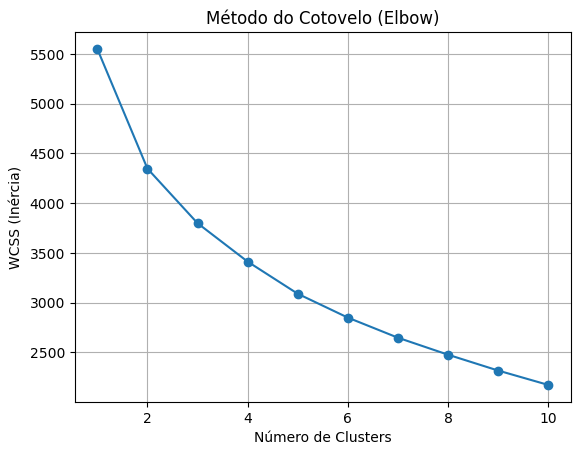

In [8]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Inércia)')
plt.title('Método do Cotovelo (Elbow)')
plt.grid()
plt.show()

In [9]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

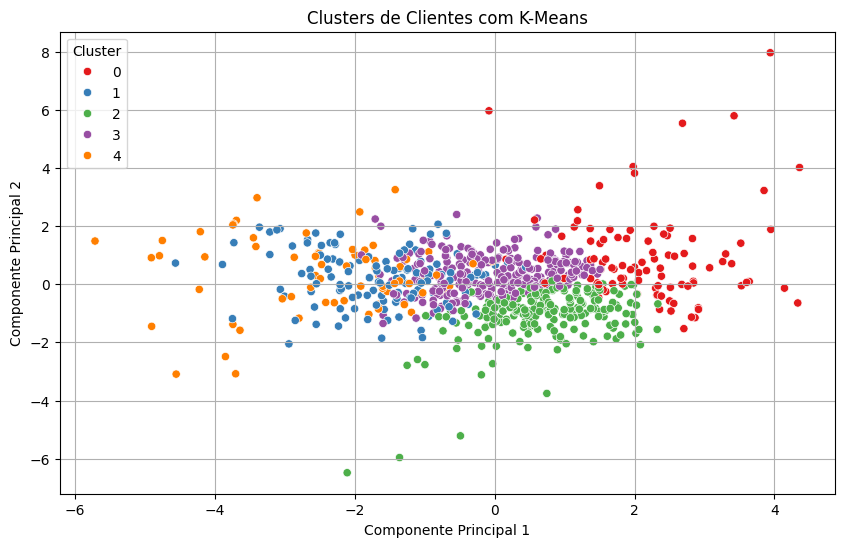

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=customer_df['Cluster'], palette='Set1')
plt.title('Clusters de Clientes com K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [11]:
cluster_profile = customer_df.groupby('Cluster')[['TotalSales', 'TotalQuantity', 'AvgDiscount', 'AvgProfit', 'Recency', 'NumCategories', 'NumRegion']].mean()
print(cluster_profile)

          TotalSales  TotalQuantity  AvgDiscount   AvgProfit     Recency  \
Cluster                                                                    
0        7988.551124      77.460000     0.127389  106.154068  123.330000   
1        1062.086790      28.023810     0.156369   20.643415  117.825397   
2        2804.027500      59.964444     0.215503   -6.632392   80.675556   
3        2376.824627      41.435897     0.111306   35.017529  106.989011   
4        1228.166691      25.971014     0.196622    5.051312  606.884058   

         NumCategories  NumRegion  
Cluster                            
0             2.900000   3.600000  
1             1.896825   2.753968  
2             2.977778   3.706667  
3             3.000000   2.945055  
4             2.376812   2.260870  


In [12]:
df_com_cluster = orders_df.merge(customer_df[['Customer ID', 'Cluster']], on='Customer ID', how='left')

df_com_cluster.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Cluster
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,1
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,1
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,3
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,3
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,3


MAE: 6.549962330734013
MSE: 212.62227735699003
R²: 0.8311866609157086


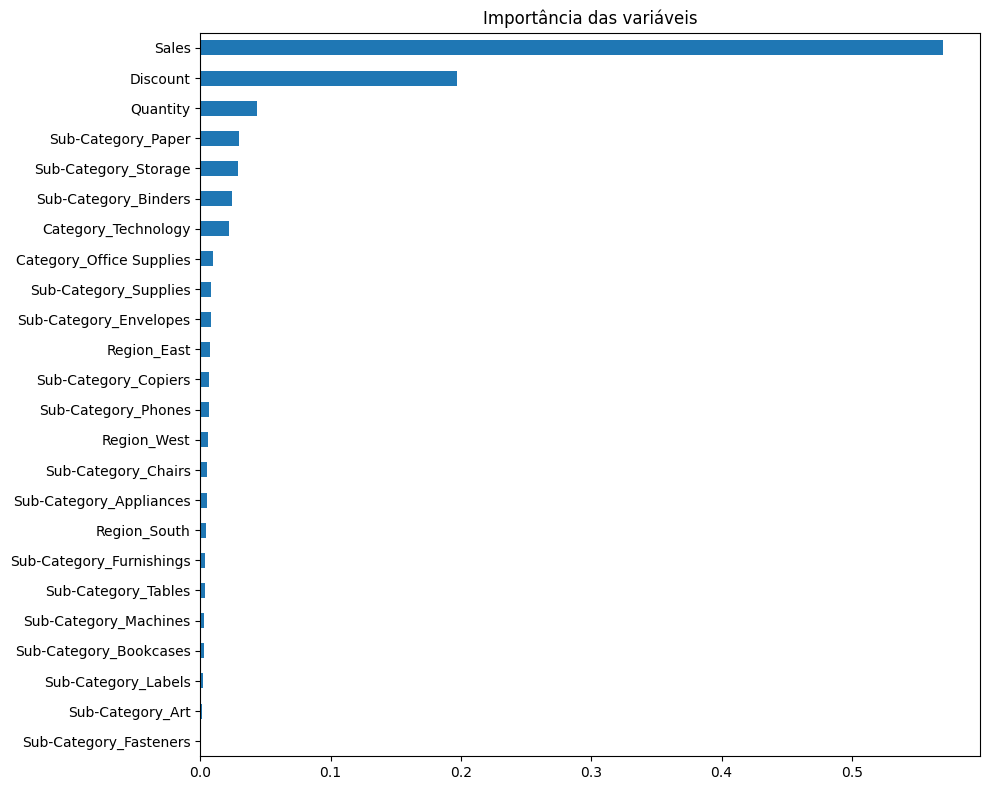

In [13]:
df_model = orders_df.copy()

df_model['Sales'] = df_model['Sales'].astype(str).str.replace(",", ".").astype(float)
df_model['Profit'] = df_model['Profit'].astype(str).str.replace(",", ".").astype(float)
df_model['Discount'] = df_model['Discount'].astype(str).str.replace(",", ".").astype(float)
df_model['Profit_per_unit'] = df_model['Profit'] / df_model['Quantity']
df_model['Profit_margin'] = df_model['Profit'] / df_model['Sales']

q1 = df_model['Profit'].quantile(0.05)
q3 = df_model['Profit'].quantile(0.95)
df_model_filtered = df_model[(df_model['Profit'] >= q1) & (df_model['Profit'] <= q3)]

features = ['Sales', 'Discount', 'Quantity', 'Category', 'Sub-Category', 'Region']
df_model_1 = df_model_filtered[features + ['Profit']]

df_model_encoded = pd.get_dummies(df_model_1, columns=['Category', 'Sub-Category', 'Region'], drop_first=True)

X = df_model_encoded.drop('Profit', axis=1)
y = df_model_encoded['Profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Avaliação
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 8), title='Importância das variáveis')
plt.tight_layout()
plt.show()

In [14]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("R² XGBoost:", r2_score(y_test, y_pred_xgb))

R² XGBoost: 0.808212969228541


In [15]:
def classificar_lucro(valor):
    if valor < 0:
        return 'Prejuízo'
    elif valor < 20:
        return 'Baixo'
    elif valor < 100:
        return 'Médio'
    else:
        return 'Alto'

df_model['Lucro_Faixa'] = df_model['Profit'].apply(classificar_lucro)

X_clf = df_model.drop(['Profit', 'Lucro_Faixa'], axis=1)
y_clf_notrt = df_model['Lucro_Faixa']
le = LabelEncoder()
y_clf = le.fit_transform(y_clf_notrt)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapeamento dos rótulos:", label_mapping)

Mapeamento dos rótulos: {'Alto': np.int32(0), 'Baixo': np.int32(1), 'Médio': np.int32(2), 'Prejuízo': np.int32(3)}


In [25]:
reg = DecisionTreeRegressor(random_state=42)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:", r2_score(y_test, y_pred))

MAE: 7.594820869057023


/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 19.089636202492052
R²: 0.7106701121700298


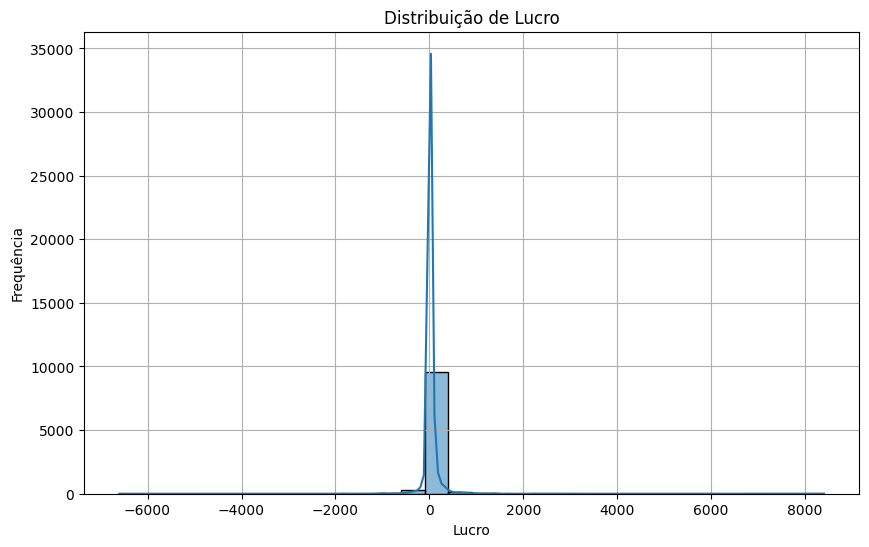

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df_model['Profit'], bins=30, kde=True)
plt.title('Distribuição de Lucro')
plt.xlabel('Lucro')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

In [22]:
df['lucro_categoria'] = pd.qcut(df_model['Profit'], q=4, labels=['Prejuízo', 'Baixo', 'Médio', 'Alto'])

0           Alto
1           Alto
2          Baixo
3       Prejuízo
4          Baixo
          ...   
9989       Baixo
9990       Médio
9991       Médio
9992       Médio
9993        Alto
Name: Profit, Length: 9994, dtype: category
Categories (4, object): ['Prejuízo' < 'Baixo' < 'Médio' < 'Alto']
